In [2]:
import numpy as np
from numba import njit
from lqfn.numerical import find_root
from lqfn import utils
from lqfn.plain_qm import SchrodingerSystem
from lqfn.plotting import plot_delta_E
import lqfn.storage as st

In [1]:
T = 10

In [3]:
eps=1.4
N_copies = 10

In [4]:
@njit
def compute_G(x,n):
    N = x.shape[0]
    g = 0
    for j in range(0,N):        
        g = g + x[j]*x[(j+n)%N]
    return g/N

Consider the potential:
$$V(x) = \frac{1}{2} m \omega_0^2 x^2 (1+cm\omega_0 x^2)$$

Here we use $m=1$, $\omega_0 = 1$ and $c = 2$

In [5]:
m = 1
omega_0 = 1
c = 2
N1 = 20
N2 = 40

In [6]:
a1 = T/N1
a2 = T/N2

---
---

In [7]:
@njit
def V(x):
    return 1/2*m*omega_0**2*x**2*(1+c*m*omega_0*x**2)

@njit
def S_per_timeslice(j, x, a):
    N = x.shape[0]
    jpp = (j+2)%N
    jp = (j+1)%N
    jm = (j-1+N)%N
    jmm = (j-2+N)%N
    Sj = -0.5*x[j]*(2*x[jp] - 2*x[j] + 2*x[jm] - (2*x[jpp] - 8*x[jp] + 6*x[j] - 8*x[jm] + 2*x[jmm])/12)/a + a*V(x[j])
    return Sj

In [8]:
an_osc_imp1 = SchrodingerSystem(T=T, N=N1, V=V, S_per_timeslice=S_per_timeslice)
an_osc_imp2 = SchrodingerSystem(T=T, N=N2, V=V, S_per_timeslice=S_per_timeslice)

In [9]:
delta_E_exact_imp1 = an_osc_imp1.get_delta_E_schrodinger()
delta_E_exact_imp2 = an_osc_imp2.get_delta_E_schrodinger()
print(fr'Delta E for new anharmonic potential with a={a1}: {delta_E_exact_imp1}')
print(fr'Delta E for new anharmonic potential with a={a2}: {delta_E_exact_imp2}')

Computing...
Took 0.537912130355835
Computing...
Took 0.48963332176208496
Delta E for new anharmonic potential with a=0.5: 0.9670716955559846
Delta E for new anharmonic potential with a=0.25: 0.4835358477779931


In [10]:
delta_E_avg_imp1, delta_E_err_imp1 = an_osc_imp1.compute_delta_E_pimc(functional=compute_G,
                                                                      N_cf=10000,
                                                                      N_cor=20,
                                                                      eps=eps,
                                                                      N_copies=N_copies,
                                                                      N_points=8)

In [11]:
delta_E_avg_imp2, delta_E_err_imp2 = an_osc_imp2.compute_delta_E_pimc(functional=compute_G,
                                                                      N_cf=10000,
                                                                      N_cor=40,
                                                                      eps=eps,
                                                                      N_copies=N_copies,
                                                                      N_points=8)

In [14]:
st.save((delta_E_avg_imp1, delta_E_err_imp1, delta_E_avg_imp2, delta_E_err_imp2), 'anharmonic_oscillator_improved')

In [15]:
delta_E_avg_imp1, delta_E_err_imp1, delta_E_avg_imp2, delta_E_err_imp2 = st.load('anharmonic_oscillator_improved')

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


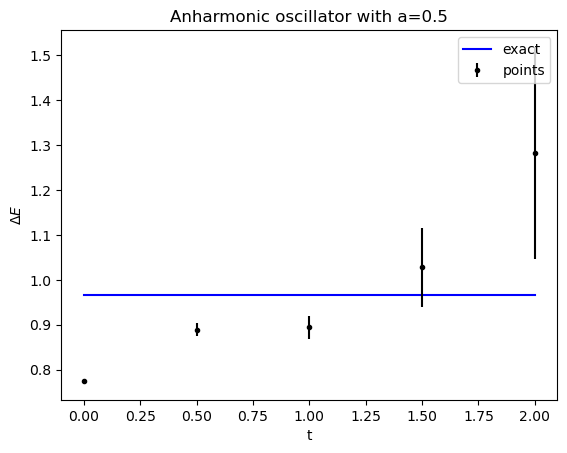

In [12]:
fig = plot_delta_E(delta_E_avg_imp1, delta_E_err_imp1,
                   exact=delta_E_exact_imp1, 
                   a=a1,
                   title=f"Anharmonic oscillator with a={a1}",
                   n=5)
fig.show()

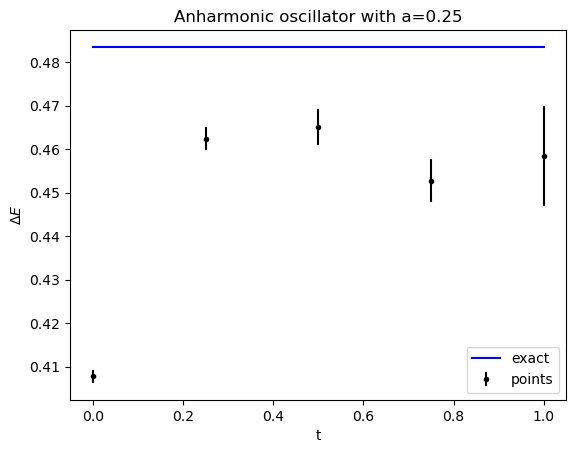

In [13]:
fig = plot_delta_E(delta_E_avg_imp2, delta_E_err_imp2,
                   exact=delta_E_exact_imp2,
                   a=a2,
                   title=f"Anharmonic oscillator with a={a2}",
                   n=5)
fig.show()

---
---

After change of variables in the path integral, the improved action looks like eq. (69) on the paper.

And then we do the path integration using the latter.

In [14]:

@njit
def V_corr(x, a, z=0):
    return 1/2*m*omega_0**2*x**2*(1+z*a+c*m*omega_0*x**2) + 1/24*a**2*m*omega_0**4*(x+2*c*m*omega_0*x**3)**2 - a*(c*m*omega_0**3*x**2/4) + 1/2*a**3*(c*m*omega_0**3*x**2/4)**2

# the following function prepares and returns S_per_timeslice with the shift correction, given a value of z
# so, if we need to create the action function with a certain value of z, we have S=factory_S_by_renormalization(z)
# and S will be the usual S_per_timeslice to be passed as a parameter to the constructor of SchrodingerSystem
def factory_S_by_renormalization(z=0):
    @njit
    def S_per_timeslice_corr(j, x, a):
        N = x.shape[0]
        jp = (j+1)%N # next site
        jm = (j-1+N)%N # previous site
        return x[j]*(x[j]-x[jp]-x[jm])/a + a*V_corr(x[j], a, z)
    return S_per_timeslice_corr

In [15]:
an_osc_corr1 = SchrodingerSystem(T=T,
                                 N=N1,
                                 V=lambda x: V_corr(x, a1),
                                 S_per_timeslice=factory_S_by_renormalization(z=0))

an_osc_corr2 = SchrodingerSystem(T=T,
                                 N=N2,
                                 V=lambda x: V_corr(x, a2),
                                 S_per_timeslice=factory_S_by_renormalization(z=0))

In [16]:
delta_E_exact_corr1 = an_osc_corr1.get_delta_E_schrodinger()
delta_E_exact_corr2 = an_osc_corr2.get_delta_E_schrodinger()
print(fr'Delta E for new anharmonic potential with a={a1}: {delta_E_exact_corr1}')
print(fr'Delta E for new anharmonic potential with a={a2}: {delta_E_exact_corr2}')

Computing...
Took 0.6052446365356445
Computing...
Took 0.523672342300415
Delta E for new anharmonic potential with a=0.5: 0.9988388927137223
Delta E for new anharmonic potential with a=0.25: 0.4817906502064284


---

In [17]:
delta_E_avg_corr1, delta_E_err_corr1 = an_osc_corr1.compute_delta_E_pimc(functional=compute_G,
                                                                         N_cf=10000,
                                                                         N_cor=50,
                                                                         eps=eps,
                                                                         N_copies=N_copies,
                                                                         N_points=8)

In [18]:
delta_E_avg_corr2, delta_E_err_corr2 = an_osc_corr2.compute_delta_E_pimc(functional=compute_G,
                                                                         N_cf=10000,
                                                                         N_cor=50,
                                                                         eps=eps,
                                                                         N_copies=N_copies,
                                                                         N_points=8)

In [30]:
import lqfn.storage as st
data = (delta_E_avg_corr1, delta_E_err_corr1, delta_E_avg_corr2, delta_E_err_corr2)
st.save(data, 'anharmonic_oscillator_corrected')

In [48]:
import lqfn.storage as st
delta_E_avg_corr1, delta_E_err_corr1, delta_E_avg_corr2, delta_E_err_corr2 = st.load('anharmonic_oscillator_corrected')

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


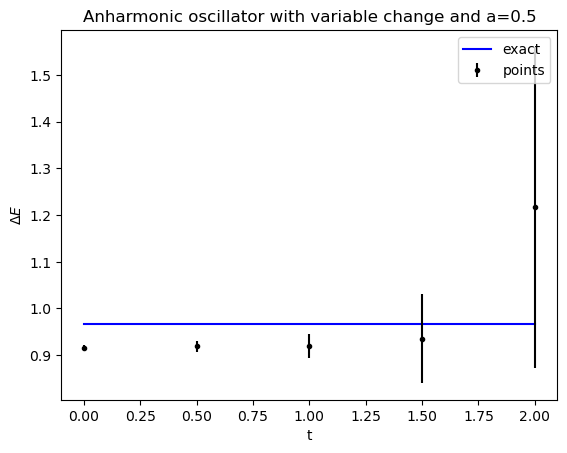

In [19]:
fig = plot_delta_E(delta_E_avg_corr1, delta_E_err_corr1,
                   exact=delta_E_exact_imp1,
                   a=a1,
                   title=f"Anharmonic oscillator with variable change and a={a1}",
                   n=5)
fig.show()

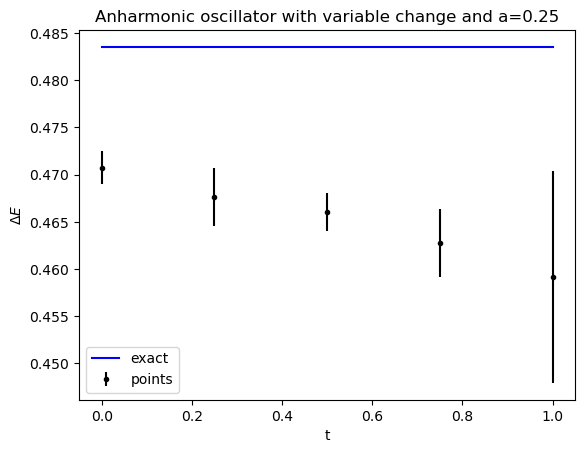

In [20]:
fig = plot_delta_E(delta_E_avg_corr2, delta_E_err_corr2,
                   exact=delta_E_exact_imp2,
                   a=a2,
                   title=f"Anharmonic oscillator with variable change and a={a2}",
                   n=5)
fig.show()

---
---

Estimate $\Delta E$ from the path integration results

In [21]:
# Choose how many points to use to estimate \Delta E
N_selected_points = 5

In [22]:
delta_E_computed_avg1, delta_E_computed_err1 = utils.get_weighted_avg_and_err(data=delta_E_avg_corr1, errs=delta_E_err_corr1, N_points=N_selected_points)
delta_E_computed_avg2, delta_E_computed_err2 = utils.get_weighted_avg_and_err(data=delta_E_avg_corr2, errs=delta_E_err_corr2, N_points=N_selected_points)

Compute the discrepancy between the obtained value and the expected value

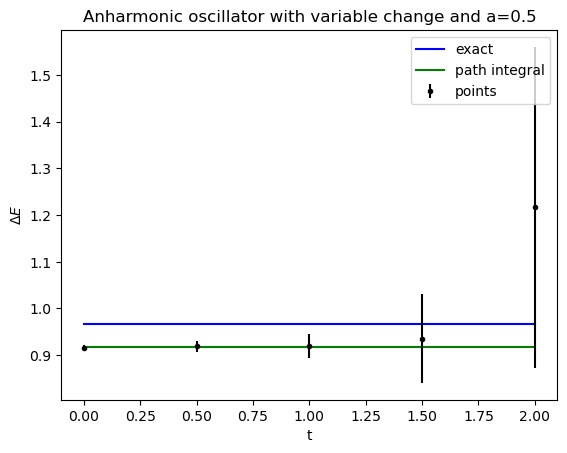

In [23]:
fig = plot_delta_E(delta_E_avg_corr1, delta_E_err_corr1,
                   exact=delta_E_exact_imp1,
                   a=a1,
                   title=f"Anharmonic oscillator with variable change and a={a1}",
                   n=N_selected_points,
                   fit=delta_E_computed_avg1)
fig.show()

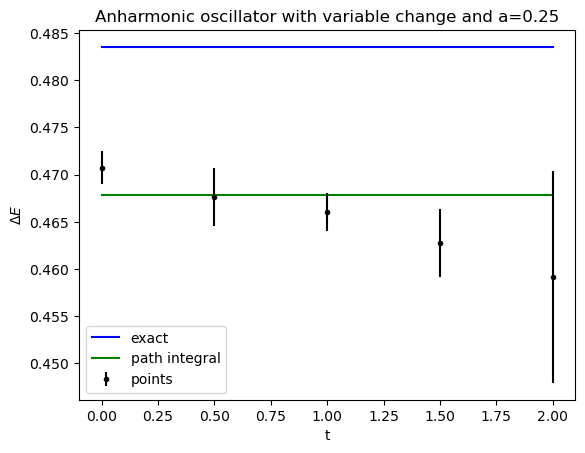

In [24]:
fig = plot_delta_E(delta_E_avg_corr2, delta_E_err_corr2,
                   exact=delta_E_exact_imp2,
                   a=a1,
                   title=f"Anharmonic oscillator with variable change and a={a2}",
                   n=N_selected_points,
                   fit=delta_E_computed_avg2)
fig.show()

In [25]:
discrepancy1 = np.abs(delta_E_exact_imp1 - delta_E_computed_avg1)/a1
discrepancy2 = np.abs(delta_E_exact_imp2 - delta_E_computed_avg2)/a2

print(f"a={a1} -> discrepancy={discrepancy1}")
print(f"a={a2} -> discrepancy={discrepancy2}")

a=0.5 -> discrepancy=0.0999781014448422
a=0.25 -> discrepancy=0.06268120378954256


---

In [35]:
# Define a function that, given z and a, computes \Delta E by path integration, and returns the discrepancy with respect to the expected value obtained by solving the schrodinger equation
def get_delta_E_value(z, a, N_points, T=T):
    system = SchrodingerSystem(T, m, int(np.round(T/a)), S_per_timeslice=factory_S_by_renormalization(z))
    delta_E_avg, delta_E_err = system.compute_delta_E_pimc(functional=compute_G, N_cf=10000, N_cor=120, eps=eps, N_copies=N_copies, N_points=N_points+1)
    delta_E_computed_avg, delta_E_computed_err = utils.get_weighted_avg_and_err(data=delta_E_avg, errs=delta_E_err, N_points=N_selected_points)
    return delta_E_computed_avg, delta_E_computed_err
    
def get_discrepancy(z, a, N_points, expected_value):
    avg, _ = get_delta_E_value(z, a, N_points)
    discrepancy = avg - expected_value
    return discrepancy

At this point, since the energy grows as z grows, we know that there must be a certain value of z that separates negative discrepancies and positive ones.
So, we apply a root finding algorithm to find the value of z that makes the path integral match the expected value.
To do this, since the evaluation of the function is computationally heavy, we exploit parallelism, and use the generalized bisection method.
We divide the z domain in 7 portions (we assume 8 CPU cores), compute the extremes of these 7 portions, and select the one that has opposite signs on the extremes.
Then, we repeat the procedure until we reach the desired precision.
The algorithm converges as fast as $7^{-n}$, where $n$ is the number of steps.

In [36]:
N_points = 2
a = 0
b = 5

In [37]:
# We want to find the root of the following function
def f(z):
    return get_discrepancy(z, a1, N_points, delta_E_exact_imp1)

z_opt, z_opt_err = find_root(f, 0, 5, num_cores=8)
print(f'z_opt={z_opt}')

[-0.05529778190312118, -0.027069502392314315, 0.00126960420668365, 0.04008395148566546, 0.07307042694930366, 0.09992342104150587, 0.12393395180310995, 0.14259515523072452]
Narrowed down to [0.7142857142857143, 1.4285714285714286]
[-0.02668951523682117, -0.013287598162817993, -0.01102399419009814, -0.0015911434947843972, -0.005654666136763797, 0.001350640318272478, 0.007420789028979136, 0.0009408254959714091]
Narrowed down to [1.1224489795918369, 1.2244897959183674]
[-0.0041023944807944135, 0.0039180744343871865, -0.009305874704039874, 0.0010937182546089108, -0.006589052056872435, -0.009023003875999414, -0.009555853640325296, 0.0012870439671828215]
Narrowed down to [1.1224489795918369, 1.1807580174927115]
z_opt=1.1516034985422743


In [38]:
st.save((z_opt, z_opt_err), 'z_opt')

In [39]:
z_opt, z_opt_err = st.load('z_opt')

In [40]:
an_osc_ren1 = SchrodingerSystem(T=T, N=N1, S_per_timeslice=factory_S_by_renormalization(z=z_opt))
an_osc_ren2 = SchrodingerSystem(T=T, N=N2, S_per_timeslice=factory_S_by_renormalization(z=z_opt))

In [46]:
delta_E_avg_ren1, delta_E_err_ren1 = an_osc_ren1.compute_delta_E_pimc(functional=compute_G,
                                                                      N_cf=10000,
                                                                      N_cor=120,
                                                                      eps=eps,
                                                                      N_copies=N_copies,
                                                                      N_points=8)

In [43]:
delta_E_avg_ren2, delta_E_err_ren2 = an_osc_ren2.compute_delta_E_pimc(functional=compute_G,
                                                                      N_cf=10000,
                                                                      N_cor=120,
                                                                      eps=eps,
                                                                      N_copies=N_copies,
                                                                      N_points=8)

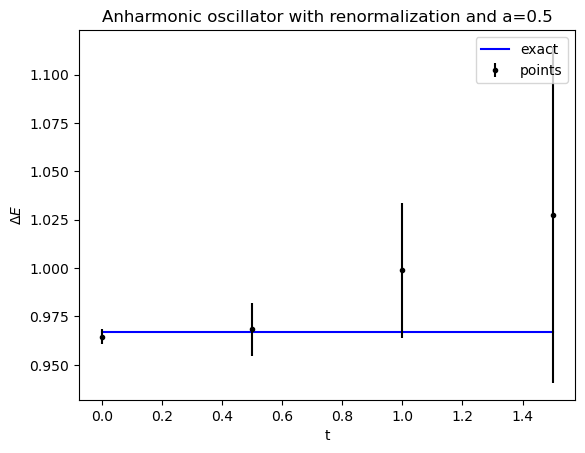

In [47]:
fig = plot_delta_E(delta_E_avg_ren1, delta_E_err_ren1,
                   exact=delta_E_exact_imp1,
                   a=a1,
                   title=f"Anharmonic oscillator with renormalization and a={a1}",
                   n=4)
fig.show()

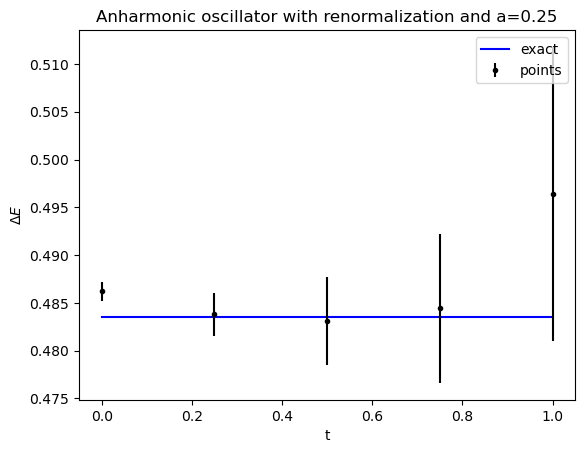

In [45]:
fig = plot_delta_E(delta_E_avg_ren2, delta_E_err_ren2,
                   exact=delta_E_exact_imp2,
                   a=a2,
                   title=f"Anharmonic oscillator with renormalization and a={a2}",
                   n=N_selected_points)
fig.show()

We see that now that the path integral is closer to the exact solution.
Of course, the computed value of z has an error of order 0.25, so we are ok with the little discrepancy that still remains.